In [43]:
import pandas as pd 
import numpy as np
import math
from sklearn import feature_extraction
from sklearn import svm
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
"""
Multiclass Naive Bayes SVM (NB-SVM)
https://github.com/lrei/nbsvm
Luis Rei <luis.rei@ijs.si> 
@lmrei
http://luisrei.com
Learns a multiclass (OneVsRest) classifier based on word ngrams.
Uses scikit learn. Reads input from TSV files.
Licensed under a Creative Commons Attribution-NonCommercial 4.0 
International License.
Based on a work at https://github.com/mesnilgr/nbsvm:
Naive Bayes SVM by Grégoire Mesnil
"""

import sys
import os
import pandas as pd
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

import six
from abc import ABCMeta
import numpy as np
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC


class NBSVM(six.with_metaclass(ABCMeta, BaseEstimator, ClassifierMixin)):

    def __init__(self, alpha=1.0, C=1.0, max_iter=10000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.C = C
        self.svm_ = [] # fuggly

    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        _, n_features = X.shape

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        # LabelBinarizer().fit_transform() returns arrays with dtype=np.int64.
        # so we don't have to cast X to floating point
        Y = Y.astype(np.float64)

        # Count raw events from data
        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.ratios_ = np.full((n_effective_classes, n_features), self.alpha,
                                 dtype=np.float64)
        self._compute_ratios(X, Y)

        # flugglyness
        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            svm = LinearSVC(C=self.C, max_iter=self.max_iter)
            Y_i = Y[:,i]
            svm.fit(X_i, Y_i)
            self.svm_.append(svm) 

        return self

    def predict(self, X):
        n_effective_classes = self.class_count_.shape[0]
        n_examples = X.shape[0]

        D = np.zeros((n_effective_classes, n_examples))

        for i in range(n_effective_classes):
            X_i = X.multiply(self.ratios_[i])
            D[i] = self.svm_[i].decision_function(X_i)
        
        return self.classes_[np.argmax(D, axis=0)]
        
    def _compute_ratios(self, X, Y):
        """Count feature occurrences and compute ratios."""
        if np.any((X.data if issparse(X) else X) < 0):
            raise ValueError("Input X must be non-negative")

        self.ratios_ += safe_sparse_dot(Y.T, X)  # ratio + feature_occurrance_c
        normalize(self.ratios_, norm='l1', axis=1, copy=False)
        row_calc = lambda r: np.log(np.divide(r, (1 - r)))
        self.ratios_ = np.apply_along_axis(row_calc, axis=1, arr=self.ratios_)
        check_array(self.ratios_)
        self.ratios_ = sparse.csr_matrix(self.ratios_)

        #p_c /= np.linalg.norm(p_c, ord=1)
        #ratios[c] = np.log(p_c / (1 - p_c))


def f1_class(pred, truth, class_val):
    n = len(truth)

    truth_class = 0
    pred_class = 0
    tp = 0

    for ii in range(0, n):
        if truth[ii] == class_val:
            truth_class += 1
            if truth[ii] == pred[ii]:
                tp += 1
                pred_class += 1
                continue;
        if pred[ii] == class_val:
            pred_class += 1

    precision = tp / float(pred_class)
    recall = tp / float(truth_class)

    return (2.0 * precision * recall) / (precision + recall)


def semeval_senti_f1(pred, truth, pos=2, neg=0): 

    f1_pos = f1_class(pred, truth, pos)
    f1_neg = f1_class(pred, truth, neg)

    return (f1_pos + f1_neg) / 2.0;


In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import WordNetLemmatizer
lemmer=WordNetLemmatizer()

def load_file(filename):
    file = open(filename, 'r', encoding='UTF-8', newline='')
    X = []
    y = []
    for line in file:
        split = line.split('\t')
        label = split[1]
        review = tokenizer.tokenize(split[0])
        review = [x.lower() for x in review]
        review = [lemmer.lemmatize(x) for x in review]
        review = " ".join(review)
        X.append(review)
        y.append(label)
    return X,y

In [63]:
X_train, y_train = load_file("IMDB-train.txt")
X_dev, y_dev = load_file("IMDB-valid.txt")
X_test, y_test = load_file("IMDB-test.txt")

In [64]:
y_final_train = np.array(y_train + y_dev)
X_final_train = np.array([row for row in X_train] + [row for row in X_dev])

In [65]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range = (1,1), binary = True)
vectorizer.fit(X_train + X_dev + X_test)
X_train = vectorizer.transform(X_train)
X_dev = vectorizer.transform(X_dev)
X_test = vectorizer.transform(X_test)
X_final_train = vectorizer.transform(X_final_train)

In [48]:
#vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range = (1,2), binary = True)
C_list = [1]
alpha_list = np.linspace(1e-4, 1e-2, 20)

num_iterations = len(C_list) * len(alpha_list)
best_score = 0
best_C = 0
best_alpha = 0

valid_scores = []
train_scores = []

for C in C_list:
    for alpha in alpha_list:
        clf = NBSVM(C = C, alpha = alpha)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        score = metrics.accuracy_score(y_dev, y_pred)
        test_score = metrics.accuracy_score(y_test, clf.predict(X_test))
        
        valid_scores.append(score)
        #train_scores.append(metrics.accuracy_score(y_train, clf.predict(X_train)))
        
        if (best_score < score):
            best_score = score
            best_C = C
            best_alpha = alpha

        print('Score: ' + str(score) + ' Current_Best: ' + str(best_score) + ' Left: ' + str(num_iterations) + ' alpha: '
              + str(alpha) + ' C: ' + str(C) + ' test_score: ' + str(test_score))
        num_iterations -= 1

Score: 0.9098 Current_Best: 0.9098 Left: 20 alpha: 0.0001 C: 1 test_score: 0.90572
Score: 0.9101 Current_Best: 0.9101 Left: 19 alpha: 0.0006210526315789474 C: 1 test_score: 0.90628
Score: 0.91 Current_Best: 0.9101 Left: 18 alpha: 0.0011421052631578948 C: 1 test_score: 0.90648
Score: 0.9096 Current_Best: 0.9101 Left: 17 alpha: 0.0016631578947368423 C: 1 test_score: 0.90656
Score: 0.9096 Current_Best: 0.9101 Left: 16 alpha: 0.0021842105263157894 C: 1 test_score: 0.9064
Score: 0.9096 Current_Best: 0.9101 Left: 15 alpha: 0.0027052631578947366 C: 1 test_score: 0.9062
Score: 0.9096 Current_Best: 0.9101 Left: 14 alpha: 0.0032263157894736843 C: 1 test_score: 0.9062
Score: 0.9095 Current_Best: 0.9101 Left: 13 alpha: 0.0037473684210526316 C: 1 test_score: 0.90612
Score: 0.9094 Current_Best: 0.9101 Left: 12 alpha: 0.004268421052631579 C: 1 test_score: 0.90616
Score: 0.9094 Current_Best: 0.9101 Left: 11 alpha: 0.004789473684210527 C: 1 test_score: 0.90612
Score: 0.9093 Current_Best: 0.9101 Left: 1

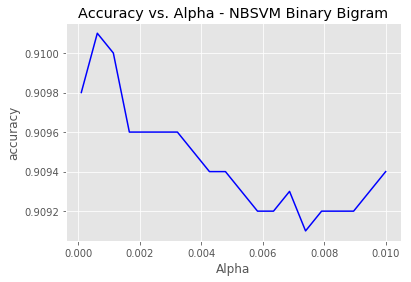

In [56]:
#plt.plot(alpha_list, train_scores, 'r', label = 'train_accuracy')
plt.plot(alpha_list, valid_scores, 'b', label = 'valid_accuracy')
plt.ylabel('accuracy')
plt.style.use('ggplot')
plt.xlabel('Alpha')
plt.title('Accuracy vs. Alpha - NBSVM Binary Bigram')
plt.savefig('(IMDB) NBSVM Binary Bigram')

In [50]:
clf = NBSVM(C =1, alpha = best_alpha)
clf.fit(X_final_train, y_final_train)

NBSVM(C=1, alpha=0.0006210526315789474, max_iter=10000)

In [51]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.90996


In [52]:
print(best_alpha)

0.0006210526315789474


In [83]:
#vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range = (1,1), binary = True)
C_list = np.linspace(0.0001, 0.01, 100)
alpha_list = [1]

num_iterations = len(C_list) * len(alpha_list)
best_score = 0
best_C = 0
best_alpha = 0

valid_scores = []
train_scores = []

for C in C_list:
    for alpha in alpha_list:
        clf = NBSVM(C = C, alpha = alpha)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        score = metrics.accuracy_score(y_dev, y_pred)
        test_score = metrics.accuracy_score(y_test, clf.predict(X_test))
        
        valid_scores.append(score)
        train_scores.append(metrics.accuracy_score(y_train, clf.predict(X_train)))
        
        if (best_score < score):
            best_score = score
            best_C = C
            best_alpha = alpha

        print('Score: ' + str(score) + ' Current_Best: ' + str(best_score) + ' Left: ' + str(num_iterations) + ' alpha: '
              + str(alpha) + ' C: ' + str(C) + ' test_score: ' + str(test_score))
        num_iterations -= 1

Score: 0.8649 Current_Best: 0.8649 Left: 100 alpha: 1 C: 0.0001 test_score: 0.86256
Score: 0.8712 Current_Best: 0.8712 Left: 99 alpha: 1 C: 0.0002 test_score: 0.87048
Score: 0.8775 Current_Best: 0.8775 Left: 98 alpha: 1 C: 0.00030000000000000003 test_score: 0.8748
Score: 0.8812 Current_Best: 0.8812 Left: 97 alpha: 1 C: 0.0004 test_score: 0.87892
Score: 0.8832 Current_Best: 0.8832 Left: 96 alpha: 1 C: 0.0005 test_score: 0.88084
Score: 0.885 Current_Best: 0.885 Left: 95 alpha: 1 C: 0.0006000000000000001 test_score: 0.88192
Score: 0.8864 Current_Best: 0.8864 Left: 94 alpha: 1 C: 0.0007000000000000001 test_score: 0.88348
Score: 0.8873 Current_Best: 0.8873 Left: 93 alpha: 1 C: 0.0008 test_score: 0.88388
Score: 0.8886 Current_Best: 0.8886 Left: 92 alpha: 1 C: 0.0009000000000000001 test_score: 0.88396
Score: 0.8899 Current_Best: 0.8899 Left: 91 alpha: 1 C: 0.001 test_score: 0.88444
Score: 0.8907 Current_Best: 0.8907 Left: 90 alpha: 1 C: 0.0011 test_score: 0.88476
Score: 0.8906 Current_Best: 0

Score: 0.8881 Current_Best: 0.8921 Left: 6 alpha: 1 C: 0.0095 test_score: 0.87348
Score: 0.8882 Current_Best: 0.8921 Left: 5 alpha: 1 C: 0.0096 test_score: 0.87336
Score: 0.8879 Current_Best: 0.8921 Left: 4 alpha: 1 C: 0.0097 test_score: 0.87332
Score: 0.8879 Current_Best: 0.8921 Left: 3 alpha: 1 C: 0.0098 test_score: 0.87336
Score: 0.8878 Current_Best: 0.8921 Left: 2 alpha: 1 C: 0.009899999999999999 test_score: 0.87312
Score: 0.8877 Current_Best: 0.8921 Left: 1 alpha: 1 C: 0.01 test_score: 0.873


In [84]:
clf = NBSVM(C =best_C, alpha = best_alpha)
clf.fit(X_final_train, y_final_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.88564


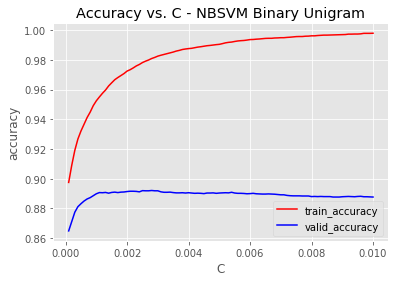

In [86]:
plt.plot(C_list, train_scores, 'r', label = 'train_accuracy')
plt.plot(C_list, valid_scores, 'b', label = 'valid_accuracy')
plt.ylabel('accuracy')
plt.style.use('ggplot')
plt.xlabel('C')
plt.title('Accuracy vs. C - NBSVM Binary Unigram')
plt.legend(loc='lower right')
plt.savefig('(IMDB) NBSVM Binary Unigram')